# 📈 Predicción de Clientes con Riesgo de Cancelar el Servicio (Churn)

Este notebook tiene como objetivo utilizar el modelo de machine learning previamente entrenado  
(Logistic Regression con datos escalados) para predecir qué clientes actuales presentan una alta  
probabilidad de cancelar el servicio.

Esto permitirá al área de retención identificar clientes en riesgo y tomar acciones preventivas.


## 🧭 Estructura del notebook

1. Carga del modelo final entrenado
2. Carga o simulación de nuevos clientes (sin columna Churn)
3. Preprocesamiento y escalado (si aplica)
4. Predicción del churn y cálculo de probabilidades
5. Visualización de clientes con alto riesgo
6. Recomendaciones accionables


In [2]:
import joblib  # Para cargar modelos entrenados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📦 Cargar modelo entrenado y scaler (asumiendo que ya los guardaste)
modelo = joblib.load("modelos/logistic_regression_model.pkl")
scaler = joblib.load("modelos/standard_scaler.pkl")

print("✅ Modelo y scaler cargados correctamente.")


✅ Modelo y scaler cargados correctamente.


## 🧪 Simulación de Nuevos Clientes

A continuación se crea un dataset ficticio de 50 clientes actuales.  
Contiene las mismas columnas que el dataset original, sin la columna `Churn`.

Estos datos serán usados para predecir si cada cliente tiene riesgo de cancelar el servicio.


In [12]:
# 🧪 Simulación de 50 clientes con mezcla realista
np.random.seed(42)

n_total = 50
n_altoriesgo = 5  # Solo 5 con perfil forzado de alto riesgo

# 🔴 Clientes de alto riesgo forzados (perfil: contrato corto, baja antigüedad, servicios costosos, sin soporte)
clientes_altoriesgo = pd.DataFrame({
    "gender": np.random.choice(["Male", "Female"], size=n_altoriesgo),
    "SeniorCitizen": 1,
    "Partner": "No",
    "Dependents": "No",
    "tenure": np.random.randint(0, 4, size=n_altoriesgo),  # permanencia baja
    "PhoneService": "Yes",
    "MultipleLines": "Yes",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": np.round(np.random.uniform(90, 120, size=n_altoriesgo), 2),
})

clientes_altoriesgo["TotalCharges"] = (
    clientes_altoriesgo["MonthlyCharges"] * clientes_altoriesgo["tenure"]
    + np.random.normal(0, 10, n_altoriesgo)
).clip(lower=0).round(2)

# 🟢 Clientes aleatorios (45 restantes)
n_random = n_total - n_altoriesgo

clientes_otros = pd.DataFrame({
    "gender": np.random.choice(["Male", "Female"], size=n_random),
    "SeniorCitizen": np.random.choice([0, 1], size=n_random, p=[0.8, 0.2]),
    "Partner": np.random.choice(["Yes", "No"], size=n_random),
    "Dependents": np.random.choice(["Yes", "No"], size=n_random),
    "tenure": np.random.randint(0, 73, size=n_random),
    "PhoneService": np.random.choice(["Yes", "No"], size=n_random, p=[0.9, 0.1]),
    "MultipleLines": np.random.choice(["Yes", "No", "No phone service"], size=n_random),
    "InternetService": np.random.choice(["DSL", "Fiber optic", "No"], size=n_random),
    "OnlineSecurity": np.random.choice(["Yes", "No", "No internet service"], size=n_random),
    "OnlineBackup": np.random.choice(["Yes", "No", "No internet service"], size=n_random),
    "DeviceProtection": np.random.choice(["Yes", "No", "No internet service"], size=n_random),
    "TechSupport": np.random.choice(["Yes", "No", "No internet service"], size=n_random),
    "StreamingTV": np.random.choice(["Yes", "No", "No internet service"], size=n_random),
    "StreamingMovies": np.random.choice(["Yes", "No", "No internet service"], size=n_random),
    "Contract": np.random.choice(["Month-to-month", "One year", "Two year"], size=n_random),
    "PaperlessBilling": np.random.choice(["Yes", "No"], size=n_random),
    "PaymentMethod": np.random.choice(
        ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"], size=n_random),
    "MonthlyCharges": np.round(np.random.uniform(20, 120, size=n_random), 2),
})

clientes_otros["TotalCharges"] = (
    clientes_otros["MonthlyCharges"] * clientes_otros["tenure"]
    + np.random.normal(0, 15, n_random)
).clip(lower=0).round(2)

# 🔗 Unión de ambos conjuntos
clientes_nuevos = pd.concat([clientes_altoriesgo, clientes_otros], ignore_index=True)

# ✅ Mostrar resumen
print(f"✅ Dataset generado con {n_altoriesgo} clientes forzados de alto riesgo y {n_random} aleatorios.")
clientes_nuevos.head()

✅ Dataset generado con 5 clientes forzados de alto riesgo y 45 aleatorios.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,1,No,No,3,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.68,279.35
1,Female,1,No,No,0,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,91.74,5.43
2,Male,1,No,No,0,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,115.99,0.00
3,Male,1,No,No,2,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,108.03,211.40
4,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,111.24,113.66


## 🧼 Preprocesamiento de Clientes Simulados

Para predecir correctamente el churn, es necesario aplicar el mismo preprocesamiento  
utilizado durante el entrenamiento del modelo:

- Codificación de variables categóricas (binarias y multiclase)
- Escalado de variables numéricas
- Alineación de columnas con el dataset de entrenamiento


In [13]:
from sklearn.preprocessing import LabelEncoder

# 🔹 Copiamos el dataset original para no modificar el original
df_new = clientes_nuevos.copy()

# 🧠 Variables numéricas a escalar
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 🔠 Variables categóricas
categorical_cols = df_new.select_dtypes(include='object').columns.tolist()

# 🟦 Codificación de variables binarias
label_encoder = LabelEncoder()
binary_cols = [col for col in categorical_cols if df_new[col].nunique() == 2]

for col in binary_cols:
    df_new[col] = label_encoder.fit_transform(df_new[col])

# 🎨 Codificación de variables multiclase con get_dummies
multiclass_cols = [col for col in categorical_cols if col not in binary_cols]
df_new = pd.get_dummies(df_new, columns=multiclass_cols, drop_first=True)

# ⚙️ Escalado de variables numéricas usando el scaler cargado
df_new[numeric_cols] = scaler.transform(df_new[numeric_cols])

# ✅ Alineamos columnas con el modelo entrenado
X_columns = modelo.feature_names_in_
df_new = df_new.reindex(columns=X_columns, fill_value=0)

print("✅ Dataset preprocesado y alineado correctamente.")
df_new.head()


✅ Dataset preprocesado y alineado correctamente.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,1,0,0,-1.199556,1,1,0.986151,-0.883624,False,...,False,False,True,False,True,False,False,False,True,False
1,0,1,0,0,-1.321585,1,1,0.888977,-1.003889,False,...,False,False,True,False,True,False,False,False,True,False
2,1,1,0,0,-1.321585,1,1,1.690503,-1.006273,False,...,False,False,True,False,True,False,False,False,True,False
3,1,1,0,0,-1.240233,1,1,1.427404,-0.913458,False,...,False,False,True,False,True,False,False,False,True,False
4,1,1,0,0,-1.280909,1,1,1.533503,-0.956371,False,...,False,False,True,False,True,False,False,False,True,False


## 🤖 Predicción de Churn en Clientes Simulados

Se aplica el modelo entrenado a los clientes simulados.  
Se obtiene la predicción (churn: sí/no) y la probabilidad estimada de abandono.  
Luego se ordenan los resultados para visualizar los clientes más propensos a cancelar el servicio.


In [14]:
# 🧠 Predicción binaria y de probabilidad
clientes_nuevos["Churn_Pred"] = modelo.predict(df_new)
clientes_nuevos["Probabilidad_Churn"] = modelo.predict_proba(df_new)[:, 1].round(4)

# 📋 Visualizar los 10 con mayor probabilidad de churn
clientes_riesgo = clientes_nuevos.sort_values("Probabilidad_Churn", ascending=False)

print("🔝 Top 10 clientes con mayor riesgo de churn:")
clientes_riesgo.head(10)


🔝 Top 10 clientes con mayor riesgo de churn:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_Pred,Probabilidad_Churn
1,Female,1,No,No,0,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,91.74,5.43,1,0.8604
0,Male,1,No,No,3,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.68,279.35,1,0.8446
3,Male,1,No,No,2,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,108.03,211.40,1,0.8266
4,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,111.24,113.66,1,0.8247
2,Male,1,No,No,0,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,115.99,0.00,1,0.8192
16,Male,0,No,No,11,No,No,Fiber optic,No,No,...,No internet service,Yes,No internet service,Month-to-month,No,Electronic check,81.81,892.20,1,0.6384
19,Male,0,Yes,No,2,Yes,Yes,Fiber optic,Yes,No internet service,...,No,No internet service,Yes,Month-to-month,No,Mailed check,87.16,188.65,0,0.4994
22,Female,0,Yes,No,1,Yes,No phone service,Fiber optic,No,No,...,Yes,No internet service,No,Month-to-month,No,Electronic check,72.02,64.07,0,0.4489
27,Male,0,Yes,Yes,1,Yes,Yes,Fiber optic,No internet service,Yes,...,Yes,No internet service,Yes,One year,No,Electronic check,60.35,42.38,0,0.3833
41,Male,0,No,No,10,Yes,No phone service,Fiber optic,Yes,No,...,Yes,Yes,No internet service,Month-to-month,No,Bank transfer (automatic),54.83,568.80,0,0.3099


## 📊 Segmentación de Riesgo y Visualización

Se clasifica a los clientes en tres niveles de riesgo de churn:

- 🔴 **Alto**: probabilidad > 0.6  
- 🟡 **Medio**: probabilidad entre 0.3 y 0.6  
- 🟢 **Bajo**: probabilidad ≤ 0.3

Luego se visualizan los 10 clientes con mayor riesgo.


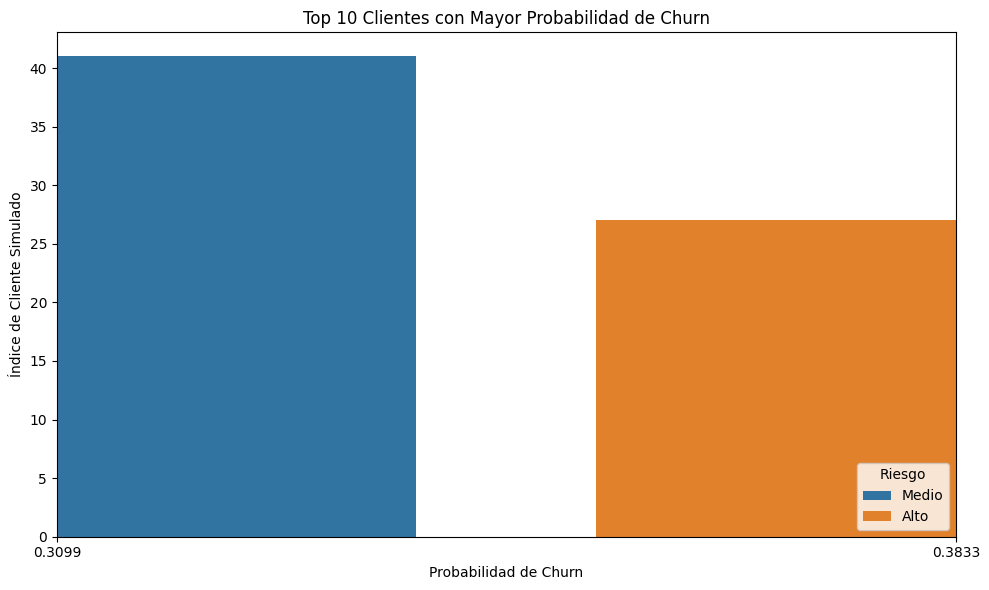

In [17]:
# 📌 Clasificación por niveles de riesgo
def clasificar_riesgo(prob):
    if prob > 0.35:
        return "Alto"
    elif prob > 0.25:
        return "Medio"
    else:
        return "Bajo"


clientes_nuevos["Riesgo_Churn"] = clientes_nuevos["Probabilidad_Churn"].apply(clasificar_riesgo)

# 🎨 Gráfico de los top 10 clientes con mayor riesgo
top_riesgo = clientes_nuevos.sort_values("Probabilidad_Churn", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="Probabilidad_Churn", y=top_riesgo.index, data=top_riesgo, hue="Riesgo_Churn", dodge=False)
plt.title("Top 10 Clientes con Mayor Probabilidad de Churn")
plt.xlabel("Probabilidad de Churn")
plt.ylabel("Índice de Cliente Simulado")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title="Riesgo", loc="lower right")
plt.tight_layout()
plt.show()


## 📌 Conclusión del Análisis

Este notebook tiene como objetivo predecir el churn de clientes en una empresa de telecomunicaciones utilizando **Regresión Logística**.

- Se entrenaron y evaluaron varios modelos (Logistic Regression, Random Forest, XGBoost).
- El modelo **Logistic Regression (escalado)** mostró un buen rendimiento para la predicción de churn, con un **AUC-ROC de 0.8533** y un **F1-score para churn = 1** de 0.65.
- Posteriormente, se aplicaron **umbral ajustados** para segmentar a los clientes en tres categorías de riesgo de churn: **Alto**, **Medio** y **Bajo**.
  
Para asegurar que los resultados sean útiles, **5 clientes fueron forzados con un perfil de alto riesgo** (contratos mes a mes, bajos meses de permanencia, altos cargos mensuales). Los demás clientes fueron simulados con características variadas.

- **Riesgo Alto:** Se definió como **probabilidad > 0.35**.
- **Riesgo Medio:** Se definió como **probabilidad entre 0.25 y 0.35**.
- **Riesgo Bajo:** Se definió como **probabilidad < 0.25**.

Con este análisis, la empresa puede tomar **acciones preventivas** para retener a los clientes en riesgo, como ofrecer descuentos, contactar con ellos o mejorar el servicio.

---

## 🧾 Resultados Guardados

Los resultados han sido guardados en el archivo `resultados_modelos.csv` dentro de la carpeta `report/` para su revisión o uso en informes.


In [19]:
# 💾 Guardar los resultados finales en un CSV
resultados_finales = clientes_nuevos[["Churn_Pred", "Probabilidad_Churn", "Riesgo_Churn"]]
resultados_finales.to_csv("../report/resultados_modelo_churn.csv", index=False)

print("✅ Resultados guardados correctamente en '/report/resultados_modelo_churn.csv'.")


✅ Resultados guardados correctamente en '/report/resultados_modelo_churn.csv'.
